# Facial Emotion Recognition - Custom Model
### Introduction
The aim of this project is to predict the age, gender and emotion of a person from an image of their face using artificial neural networks trained on images from the FER-2013 facial recognition dataset.

We investigate the accuracy of age, gender and emotion prediction using use different neural network models. We evaluate each model using accuracy, F1 score, L1 mean absolute error, and training time.

This notebook predicts facial emotion using a custom neural network model.

In [3]:
!pip install poutyne
!pip install torchsummary
!pip install torchviz

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 47.0/47.0 kB 2.3 MB/s eta 0:00:00
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=2a65d7b57f5ceb7f55c0136306f2d886f021c464bf0ee1761b4a1c97a956554b
  Stored in directory: c:\users\edwar\appdata\local\pip\cache\wheels\29\65\6e\db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz


In [4]:
import os
import tarfile
import urllib.request
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
import torch.onnx
from torch.utils import model_zoo
from torch.utils.data import Subset, DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Experiment, EarlyStopping, ReduceLROnPlateau, TensorBoardLogger
from zipfile import ZipFile
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torchviz import make_dot

## Download and prepare the FER 2013 dataset

In [5]:
set_seeds(42)
base_path = './datasets/fer_2013'
zip_file_name = 'fer_2013.zip'
base_image_path = os.path.join(base_path, 'images')
zip_url = 'https://storage.googleapis.com/unsw_comp9444/fer_2103/fer_2013.zip'

mma_base_path = './datasets/mma_facial_recognition'
mma_zip_file_name = 'mma_facial_expression.zip'
mma_base_image_path = os.path.join(mma_base_path, 'images')
mma_download_url = 'https://storage.googleapis.com/unsw_comp9444/facial_expressions/mma_facial_expression.zip'

#### Download and extract dataset images
Dataset: https://www.kaggle.com/datasets/msambare/fer2013

In [6]:
def download_and_extract_dataset(base_path, extract_path, file_name, zip_url):
    os.makedirs(base_path, exist_ok=True)
    os.makedirs(extract_path, exist_ok=True)
    zip_filename = os.path.join(base_path, file_name)

    print('Downloading dataset...')
    urllib.request.urlretrieve(zip_url, zip_filename)
    print('Extracting archive...')
    with ZipFile(zip_filename, 'r') as zip_obj:
       zip_obj.extractall(path=extract_path)
    
download_and_extract_dataset(base_path, base_image_path, zip_file_name, zip_url)
download_and_extract_dataset(mma_base_path, mma_base_image_path, mma_zip_file_name, mma_download_url)   

Extracting archive...
Extracting archive...


#### Setup training constants

In [29]:
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

num_classes = 7
batch_size = 32
test_batch_size = 128
learning_rate = 0.0001
weight_decay = 0.001
n_epoch = 70
image_size = 48 #original size of the image

#### Create datasets and image transforms

In [13]:
augment_transform = transforms.Compose(
    [                
        transforms.ToTensor(),
        transforms.RandomAffine(degrees = 5, translate = (0.1, 0.1), shear = 5),    
        transforms.RandomHorizontalFlip(),
        #transforms.RandomAutocontrast(),
        #transforms.RandomVerticalFlip(),
        #transforms.RandomPerspective(),    
        transforms.Grayscale(1),
        transforms.Normalize((0.5,), (0.25,))
    ]
)

normalize_transform = transforms.Compose(
    [        
        transforms.ToTensor(),
        transforms.Grayscale(1),
        transforms.Normalize((0.5,), (0.25,))
    ]
)

train_image_path = os.path.join(base_image_path, 'train')
test_image_path = os.path.join(mma_base_image_path, 'test')

train_dataset = ImageFolder(
    train_image_path,
    transform=augment_transform,
    is_valid_file=lambda path: not os.path.split(path)[1].startswith('.'),
)

test_valid_dataset = ImageFolder(
    test_image_path,
    transform=normalize_transform,
    is_valid_file=lambda path: not os.path.split(path)[1].startswith('.'),
)

In [14]:
class TransformDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        item, label = self.dataset[index]
        if self.transform is None:
              return item, label
        
        return self.transform(item), label  

    def __len__(self):
        return len(self.dataset) 
    
    def get_labels(self):
        return [x[1] for x in self.dataset.imgs]
        

Use 50% of the test dataset for validation

In [15]:
test_dataset_size = int(len(test_valid_dataset) * 0.5)
dataset_lengths = [test_dataset_size, len(test_valid_dataset) - test_dataset_size]
test_dataset, valid_dataset = random_split(test_valid_dataset, dataset_lengths)

#### Example face images

C:\Users\edwar\AppData\Local\Temp\ipykernel_7904\1108147587.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


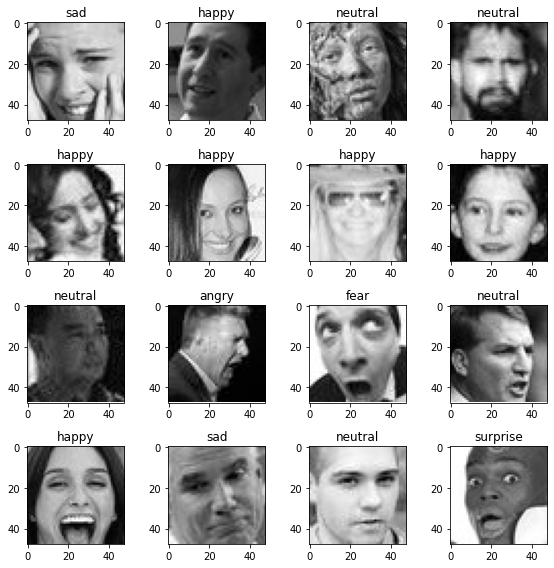

In [16]:
def show_batch(dataset):
    fig, ax = plt.subplots(4, 4, figsize=(8, 8))
    for i, (image, label) in enumerate(dataset):
        ax[i % 4, i // 4].set_title(train_dataset.classes[label])
        ax[i % 4, i // 4].imshow(image.permute(1, 2, 0), cmap='gray')
        if i >= 15:
            break
            
    fig.tight_layout()
    fig.show()            
            
show_batch(test_dataset)          

#### Dataset sizes and classes

In [17]:
print(f'training dataset size: {len(train_dataset)}')
print(f'validaiton dataset size: {len(valid_dataset)}')
print(f'test dataset size: {len(test_dataset)}')

print(f'classes: {train_dataset.classes}')
print(f'class indexes: {train_dataset.class_to_idx}')

training dataset size: 28709
validaiton dataset size: 8678
test dataset size: 8678
classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class indexes: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


FileNotFoundError: [Errno 2] No such file or directory: 'plots/faces/emotion_distribution.png'

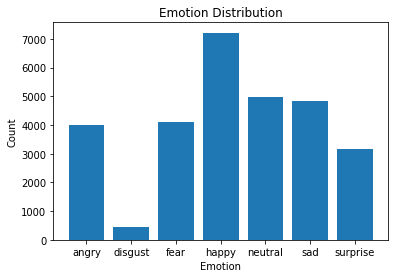

In [18]:
emotion_counts = dict(Counter(train_dataset.targets))

emotion_names = [train_dataset.classes[i] for i in list(emotion_counts.keys())]
emotion_values = list(emotion_counts.values())
plt.bar(range(len(emotion_counts)), emotion_values, tick_label=emotion_names)
plt.title("Emotion Distribution")
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.savefig('plots/faces/emotion_distribution.png')
plt.show()

#### Create dataloaders for train, validation and test datasets

In [19]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=test_batch_size, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, num_workers=0)

## Create CNN model for facial emotion recognition and classification

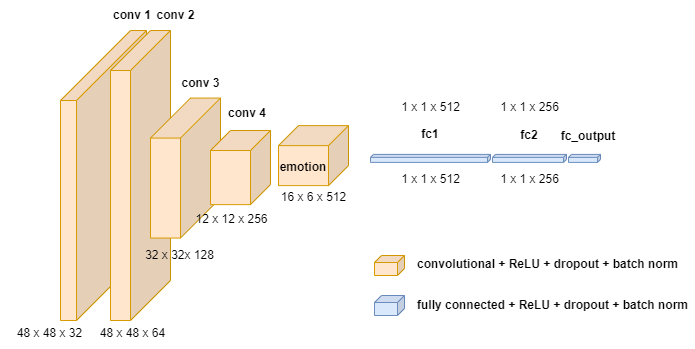

In [20]:
class FaceNetwork(nn.Module):
    def __init__(self):
        super(FaceNetwork, self).__init__()
        
        self.maxpool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)    
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn_conv2 = nn.BatchNorm2d(64)
        self.dropout_conv2 = nn.Dropout2d(0.25)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn_conv3 = nn.BatchNorm2d(128)
        self.dropout_conv3 = nn.Dropout2d(0.25)        
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn_conv4 = nn.BatchNorm2d(256)
        self.dropout_conv4 = nn.Dropout2d(0.25)        
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn_conv5 = nn.BatchNorm2d(512)    
        self.dropout_conv5 = nn.Dropout2d(0.25)        
        
        self.fc1 = nn.Linear(4608, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.dropout_fc2 = nn.Dropout(0.25)
        
        self.fc_out = nn.Linear(256, 7)
        
    def forward(self, input):    
        output = F.relu(self.conv1(input))      
        output = F.relu(self.conv2(output))
        output = self.bn_conv2(output)    
        output = self.maxpool(output)   
        output = self.dropout_conv2(output)
        
        output = F.relu(self.conv3(output))
        output = self.bn_conv3(output)    
        output = self.maxpool(output)   
        output = self.dropout_conv3(output)
        
        output = F.relu(self.conv4(output))
        output = self.bn_conv4(output)        
        output = self.maxpool(output)    
        output = self.dropout_conv4(output)
        
        output = F.relu(self.conv5(output))
        output = self.bn_conv5(output)
        output = self.maxpool(output)            
        output = self.dropout_conv5(output)    
        
        # Flattening process
        output = torch.flatten(output, start_dim=1)
        
        #output = self.fc1(output)
        output = F.relu(self.fc1(output))
        output = self.bn_fc1(output)
        output = self.dropout_fc1(output)    
        
        #output = self.fc2(output)
        output = F.relu(self.fc2(output))
        output = self.bn_fc2(output)
        output = self.dropout_fc2(output)    
        
        output = self.fc_out(output)
        
        return output
    
face_network = FaceNetwork().to(device)
print(summary(face_network, input_size=(1, image_size, image_size)))    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
            Conv2d-2           [-1, 64, 48, 48]          18,496
       BatchNorm2d-3           [-1, 64, 48, 48]             128
         MaxPool2d-4           [-1, 64, 24, 24]               0
         Dropout2d-5           [-1, 64, 24, 24]               0
            Conv2d-6          [-1, 128, 24, 24]          73,856
       BatchNorm2d-7          [-1, 128, 24, 24]             256
         MaxPool2d-8          [-1, 128, 12, 12]               0
         Dropout2d-9          [-1, 128, 12, 12]               0
           Conv2d-10          [-1, 256, 12, 12]         295,168
      BatchNorm2d-11          [-1, 256, 12, 12]             512
        MaxPool2d-12            [-1, 256, 6, 6]               0
        Dropout2d-13            [-1, 256, 6, 6]               0
           Conv2d-14            [-1, 51

## Train the CNN for facial emotion classification on the FER 2013 dataset
#### Create training callbacks for saving last epoch, best epoch, reducing learning rate, early stopping and logging the results

In [25]:
save_base_dir = 'saves'
save_path = os.path.join(save_base_dir, 'fer_faces')

plots_dir = 'plots/faces'
os.makedirs(plots_dir, exist_ok=True)

summary_writer = SummaryWriter('runs')

callbacks = [
    # Save the latest weights to be able to resume the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_epoch.ckpt')),
    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(
        os.path.join(save_path, 'best_epoch_{epoch}.ckpt'),
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        restore_best=True,
        verbose=True,
    ),
    # Save TensorBoard data
    TensorBoardLogger(summary_writer),
    #EarlyStopping(patience=15, verbose=True),
    ReduceLROnPlateau(monitor='val_loss', factor = 0.2, verbose=True),    
    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

#### Create training optimizer, loss function and Poutyne model. Train the CNN network and evaluate validation and test datsets

In [30]:
optimizer = optim.Adam(face_network.parameters(), lr=learning_rate, weight_decay = weight_decay)

loss_function = nn.CrossEntropyLoss()

model = Model(
    face_network,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    epoch_metrics=['f1'],
    device=device,
)

model.fit_generator(
    train_loader,
    valid_loader,
    epochs=n_epoch,
    
)

test_loss, (test_acc, test_f1), y_predict, y_true = model.evaluate_generator(test_loader, return_pred=True, return_ground_truth=True)

Epoch:  1/20 Step:  51/898   5.68% |█▏                  |ETA: 3m36.16s loss: 2.003599 acc: 9.375000 

KeyboardInterrupt: 

## Results, accuracy and confusion matrix

In [15]:
logs = pd.read_csv(os.path.join(save_path, 'log.tsv'), sep='\t')
print(logs)

best_epoch_idx = logs['val_acc'].idxmax()
best_epoch = int(logs.loc[best_epoch_idx]['epoch'])
print("Best epoch: %d" % best_epoch)

     epoch        time       lr      loss        acc  fscore_macro  val_loss  \
0        1  200.410674  0.00010  1.914539  24.734404      0.206205  1.875814   
1        2   61.748330  0.00010  1.723935  33.334494      0.251635  1.620224   
2        3   65.816028  0.00010  1.597928  38.228430      0.287914  1.492971   
3        4   66.143154  0.00010  1.508618  41.837055      0.324996  1.438971   
4        5   66.703538  0.00010  1.437145  44.536556      0.353234  1.299470   
..     ...         ...      ...       ...        ...           ...       ...   
115    116   63.991613  0.00002  0.738111  72.562611      0.710816  0.844375   
116    117   63.680929  0.00002  0.732389  72.775088      0.712392  0.838177   
117    118   63.926658  0.00002  0.729959  73.081612      0.720108  0.847804   
118    119   63.889675  0.00002  0.729964  73.039813      0.716289  0.838579   
119    120   64.448770  0.00002  0.722264  73.067679      0.716845  0.843589   

       val_acc  val_fscore_macro  
0   

#### Plot loss, accuracy and confusion matrix

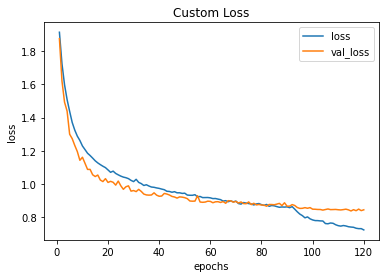

In [16]:
metrics = ['loss', 'val_loss']
plt.title('Custom Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.savefig('plots/faces/emotion_loss.png')
plt.show()

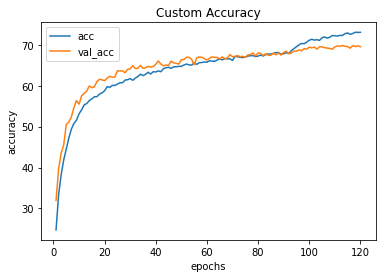

In [17]:
metrics = ['acc', 'val_acc']
plt.title('Custom Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.savefig('plots/faces/emotion_accuracy.png')
plt.show()

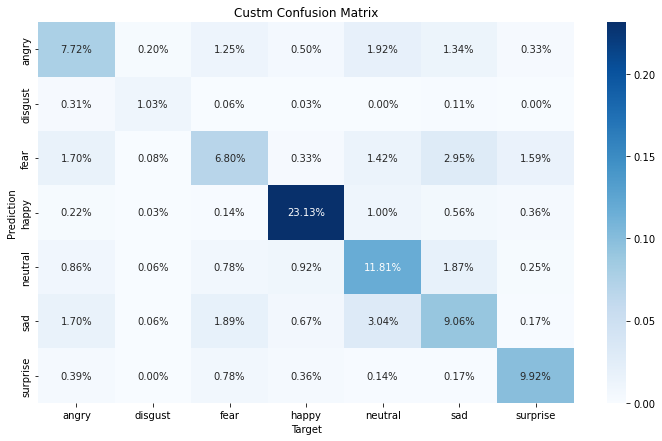

In [18]:
cf_matrix = confusion_matrix(y_true, np.argmax(y_predict, axis=1))
class_names = train_dataset.classes

plt.figure(figsize = (12,7))
plt.title('Custm Confusion Matrix')
sn.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.savefig('plots/faces/emotion_confusion_matrix.png')
plt.show()

## Discussion

Most results reported on Kaggle using the FER 2013 dataset had an accuracy of 0.60 to 0.67 (https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/leaderboard).

Our custom model produced results slightly better with an accuracy of 0.69 and a training time of around 126 minutes.

The graphs of training accuracy and loss verses validation accuracy and loss show over-fitting of training data after about 100 training epochs. 

If more time and computing resources are available, a grater range of image augmentation, dropout and  weight_decay should be investigated to reduce over-fitting.

#### Kaggle Competition Leaderboard Top 10
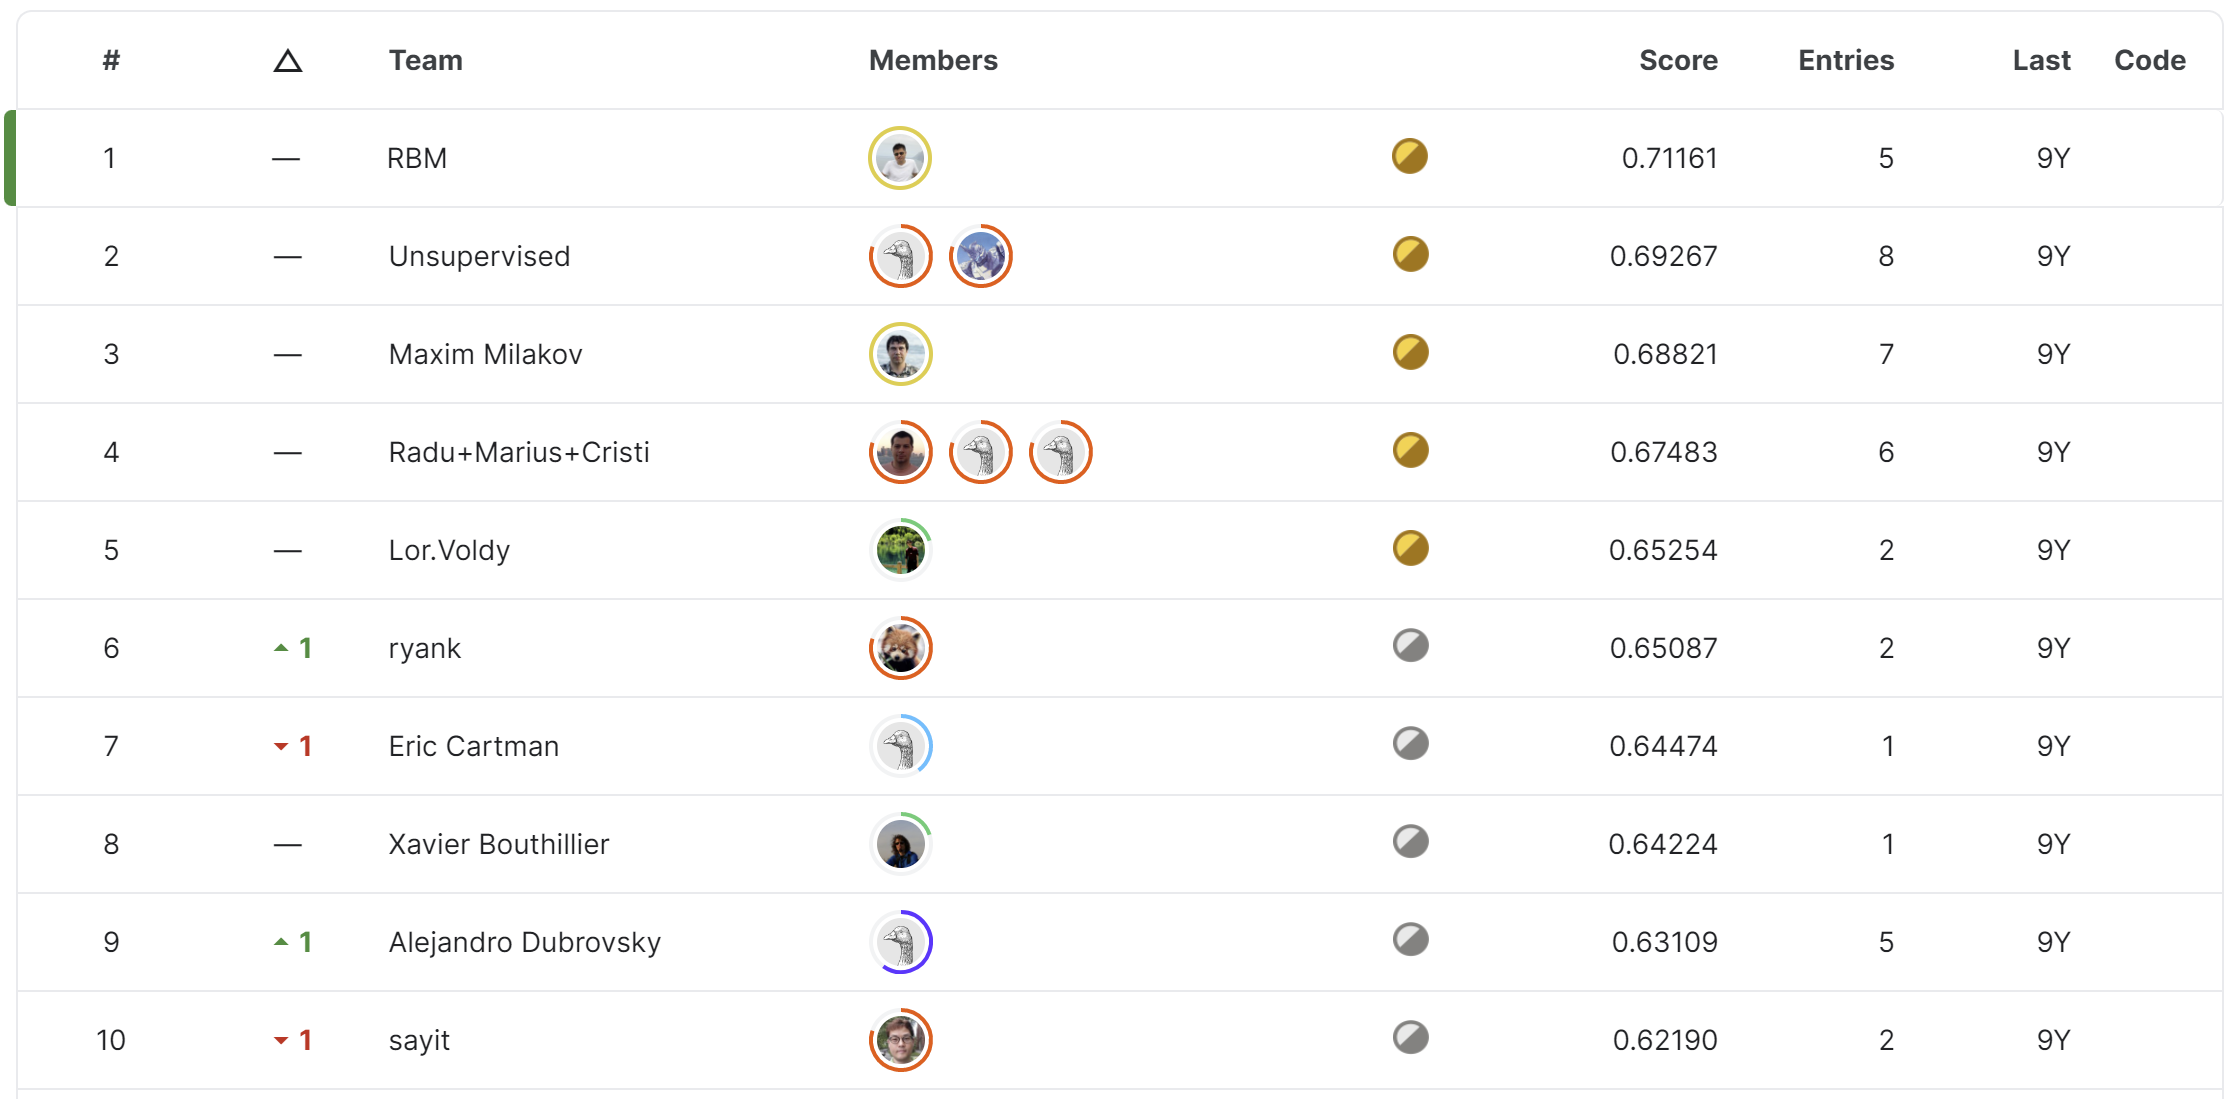